In [1]:
import scipy.signal as sig
import scipy
import numpy as np
import matplotlib.pyplot as plt
import h5py

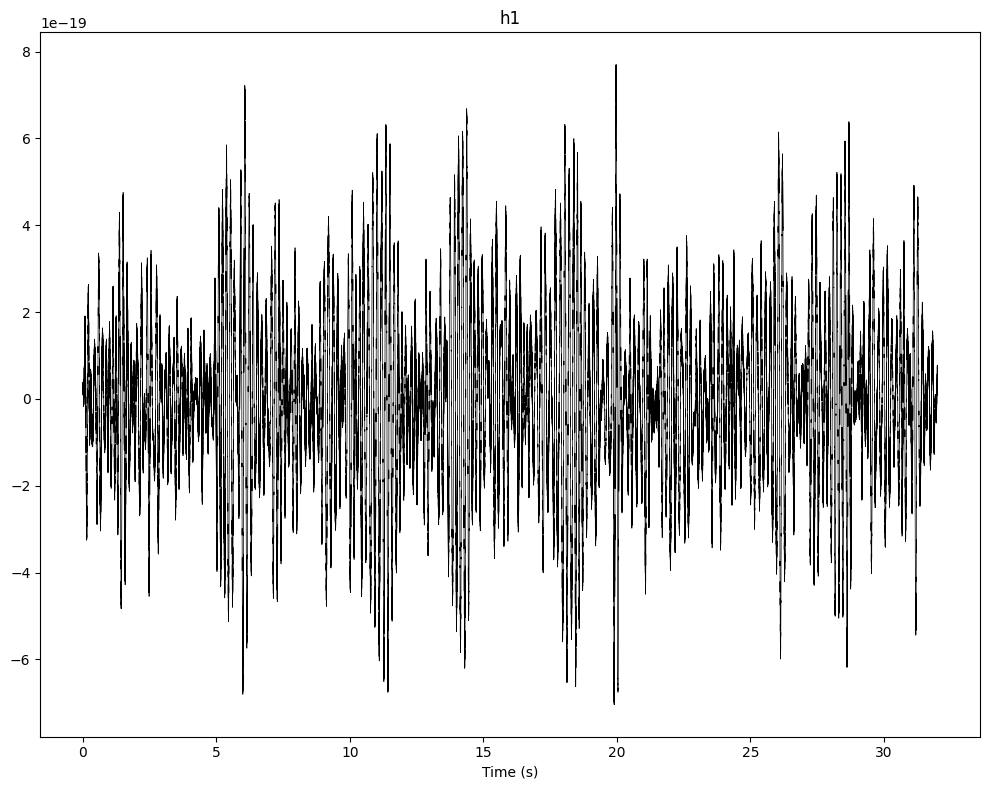

In [2]:
filename_h1 = 'h1_4khz_32s.hdf5'


with h5py.File(filename_h1, 'r') as f_h1:
    h1_s = f_h1['strain/Strain'][...]
    h1_fs = 1 / f_h1['strain/Strain'].attrs['Xspacing']
    h1_st = f_h1['meta/GPSstart'][()]

gw_time = 1126259462.442
gw_st = gw_time - h1_st
gw_large = 0.2
time = np.arange(0,h1_s.shape[0]/h1_fs, 1/h1_fs)


fig, (ax1) = plt.subplots(1, 1, figsize=(10, 8))
ax1.plot(time, h1_s, linewidth=0.5, color= "black")
ax1.set_title('h1')
ax1.set_xlabel('Time (s)')


plt.tight_layout()
plt.show()

N = 1
h1_gw = h1_s[(time >= gw_st-N) & (time <= gw_st + N)]
time_gw = time[(time >= gw_st-N) & (time <= gw_st + N)]

h1_ruido = h1_s[(time > gw_st + N)]
time_ruido = time[(time > gw_st + N)]

In [3]:
def periodogram(x, win):
    N = len(x)
    w = scipy.signal.get_window(Nx = N, window = win)
    Rx = (scipy.fft.fft(x*w))**2 * (1/N)
    return Rx
    

c:\Users\joaco\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


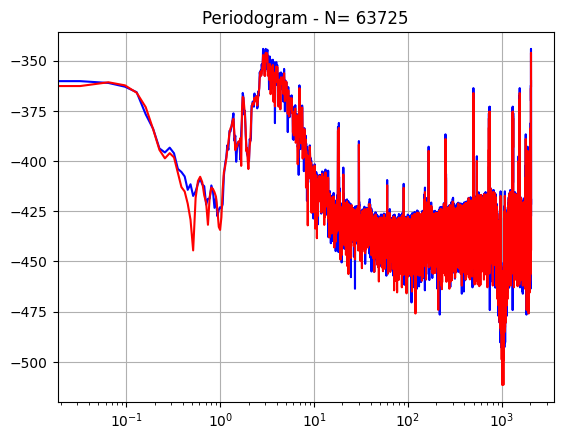

In [4]:
Rx = periodogram(h1_ruido, 'bartlett')
Rx2 = periodogram(h1_ruido, 'parzen')
x_ax = np.linspace(0,0.5, len(Rx)) * h1_fs
plt.plot(x_ax, 10*np.log10(Rx), 'blue')
plt.plot(x_ax, 10*np.log10(Rx2), 'red')
plt.title('Periodogram - N= ' + str(len(h1_ruido)))
plt.grid()
plt.xscale("log")
plt.show()

In [47]:
def autocorr(x, L): 
    return scipy.signal.correlate(x,x, 'full')/len(x)

def apply_window(rx, L, win):
    N = len(rx)
    window = scipy.signal.get_window(Nx = 2*L+1, window = win)
    pw = int((N-len(window))/2)

    padded_window = np.pad(array = window, pad_width=pw) 
    return rx*padded_window


def blackman_tuckey(signal, L, w):
    rx = autocorr(signal, L)
    N = len(h1_ruido)
    Rx_smoothing = abs(scipy.fft.fft(apply_window(rx, L, w)))
    return Rx_smoothing[:len(h1_ruido)]

In [6]:
def welch_bartlett(signal, w, segment_size, overlap = 0):
    
    X_prom = np.zeros(segment_size)
    N = len(signal)
    i=0
    segment_count = 0
    d = int(segment_size*(1-overlap))
    while i+segment_size<N:
        segment = signal[i:i+segment_size]
        s_len = len(segment)
        Xr = abs(scipy.fft.fft(segment*scipy.signal.get_window(Nx = s_len, window = w)))   
        X_prom += np.power(Xr, 2)
        i=i+d   
        segment_count+=1 


    X_prom /= (segment_count*segment_size)
    
    return X_prom[:int(segment_size/2)]

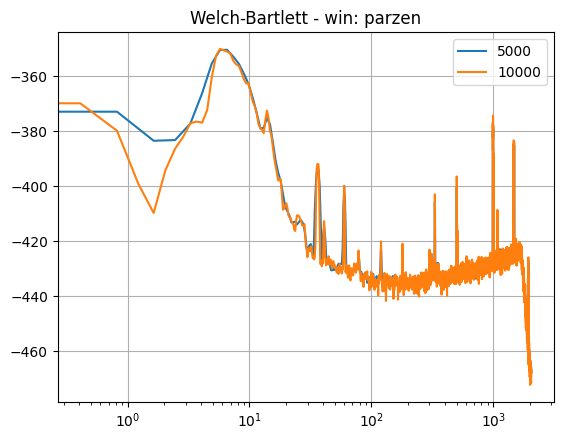

In [7]:
w = 'parzen'
L = 15000
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.25)
#plt.plot(np.array(range(len(Rx_pa)))/len(Rx_pa),20*np.log10(Rx_pa), label = L)
plt.title('Welch-Bartlett - win: ' + w)
#plt.grid()
#plt.xscale("log")





w = 'parzen'
L = 5000
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.25)
x_ax = np.linspace(0,0.5, len(Rx_pa)) * h1_fs
plt.plot(x_ax, 10*np.log10(Rx_pa), label = L)
#plt.title('Welch-Bartlett - win: ' + w)
#plt.grid()
#plt.xscale("log")


w = 'parzen'
L = 10000
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.25)
x_ax = np.linspace(0,0.5, len(Rx_pa)) * h1_fs


plt.plot(x_ax, 10*np.log10(Rx_pa), label = L)
#plt.title('Welch-Bartlett - win: ' + w)
plt.grid()
plt.xscale("log")

plt.legend()
plt.show()

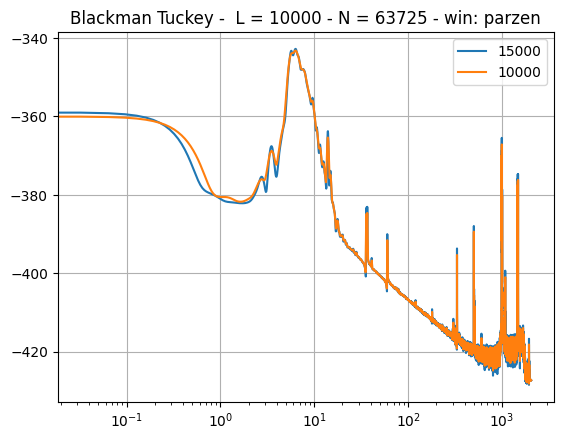

In [8]:
L = 15000
w = 'parzen'

smoothRx = blackman_tuckey(h1_ruido, L, w)
x_ax = np.linspace(0,0.5, len(smoothRx)) * h1_fs
plt.plot(x_ax, 10*np.log10(smoothRx), label = str(L))

L =10000
w = 'parzen'
smoothRx = blackman_tuckey(h1_ruido, L, w)
plt.plot(x_ax, 10*np.log10(smoothRx), label = str(L))
plt.title('Blackman Tuckey -  L = ' + str(L) + ' - N = ' + str(len(h1_ruido)) + ' - win: ' + w)
plt.grid()
plt.xscale("log")
plt.legend()

plt.show()


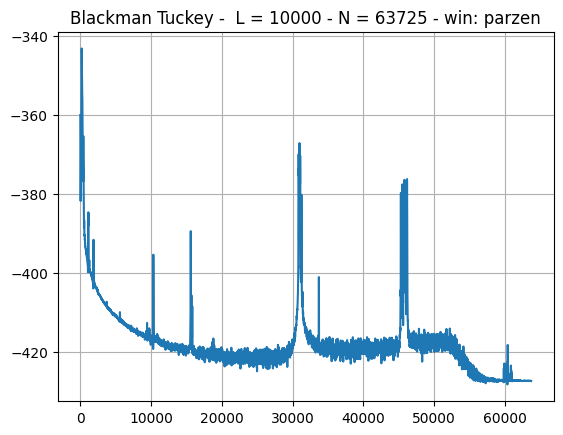

In [9]:
plt.plot(10*np.log10(smoothRx))
plt.title('Blackman Tuckey -  L = ' + str(L) + ' - N = ' + str(len(h1_ruido)) + ' - win: ' + w)
plt.grid()
plt.show()

In [10]:
print(scipy.signal.correlate([1,2,3],[1,2,3], 'full'))
print(np.correlate([1,2,3],[1,2,3], 'valid'))

[ 3  8 14  8  3]
[14]


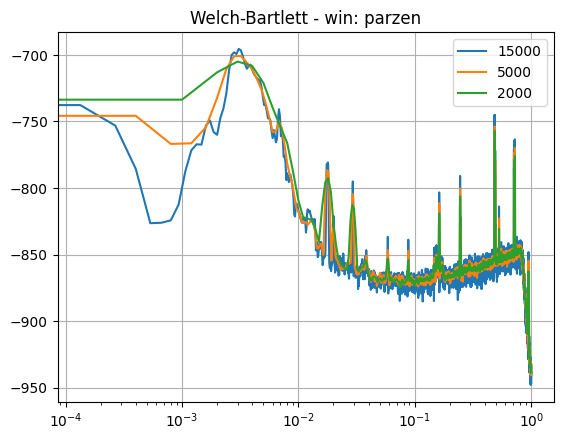

In [11]:
w = 'parzen'
L = 15000
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.25)
plt.plot(np.array(range(len(Rx_pa)))/len(Rx_pa),20*np.log10(Rx_pa), label = L)
plt.title('Welch-Bartlett - win: ' + w)
#plt.grid()
#plt.xscale("log")

w = 'parzen'
L = 5000
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.25)
plt.plot(np.array(range(len(Rx_pa)))/len(Rx_pa),20*np.log10(Rx_pa), label = L)
#plt.title('Welch-Bartlett - win: ' + w)
#plt.grid()
#plt.xscale("log")

w = 'parzen'
L = 2000
Rx_pa = welch_bartlett(h1_ruido, w, L, overlap=0.25)
plt.plot(np.array(range(len(Rx_pa)))/len(Rx_pa), 20*np.log10(Rx_pa), label = L)
#plt.title('Welch-Bartlett - win: ' + w)
plt.grid()
plt.xscale("log")
plt.legend()
plt.show()

In [12]:
h1_fs

4096.0